<a href="https://colab.research.google.com/github/venkataramanik/Supplychain/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Project 7 – Demand Forecasting Using LSTM Neural Networks

## 🔍 What is an LSTM?

**LSTM (Long Short-Term Memory)** networks are a special type of Recurrent Neural Network (RNN) designed to learn from **sequential data** — like time series — by remembering long-term dependencies.

Unlike statistical models (ARIMA) or tree-based models (XGBoost), LSTMs **learn patterns directly from raw sequences** without needing a lot of manual feature engineering.

---

## 📦 Why Use LSTM for Forecasting?

LSTMs are ideal when:

- There are **nonlinear, time-dependent patterns** in demand
- You want to predict **multi-step forecasts** (e.g., next 4 or 8 weeks)
- External factors (price, promotions, weather) interact with past values
- There's **long memory** in customer or supply patterns (lags > 4–5 weeks)

---

## 🏭 Industry Use Cases

### 🛍️ Retail & E-commerce

- Predict seasonal or flash-sale demand using previous weeks’ data
- Model **holiday peaks, trends, and product decay** patterns

### 🚛 Logistics & Transportation

- Forecast order or shipment volume to allocate fleet capacity
- Learn **multi-hub route delays or fulfillment speed patterns**

### 🏭 Manufacturing & Inventory Planning

- Estimate raw material or component consumption based on production sequences
- Avoid bullwhip effect by modeling **supplier-customer chain reactions**

### 📈 Other Examples

- **Energy**: Electricity or fuel demand
- **Healthcare**: Medical inventory (PPE, vaccines, beds)
- **Airlines**: Passenger load forecasting on future routes

---

## 📊 What You'll Build

- Scaled weekly demand data as a time series
- Train/test splits with input/output sequence windows
- Build an LSTM model using TensorFlow/Keras
- Forecast demand for future weeks
- Visualize prediction vs actual
- Evaluate performance using MAPE/MAE

---

📌 LSTM is widely used in **real-world AI supply chain systems**, including companies like Amazon, TikTok, and Walmart.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


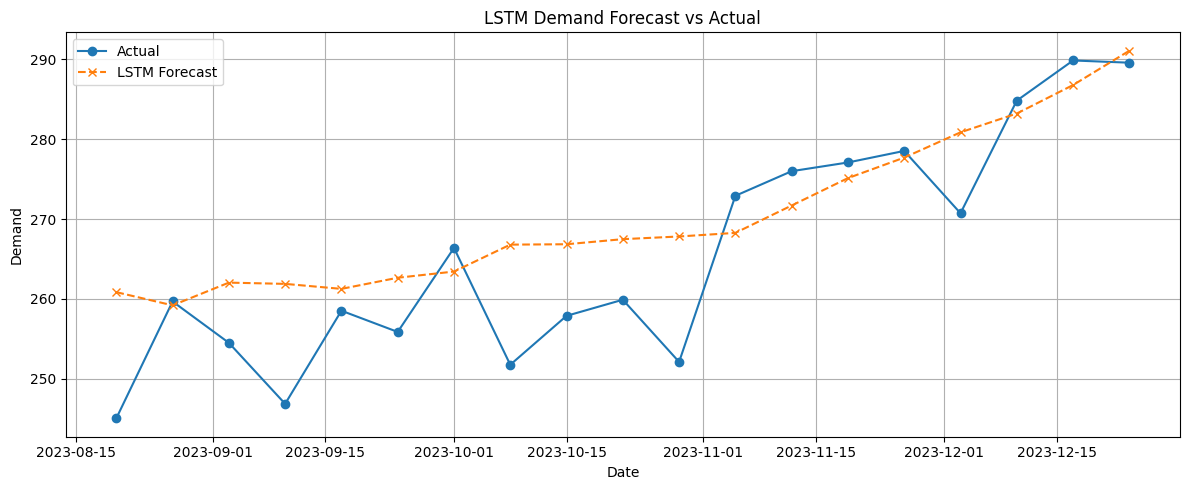

MAPE: 2.59%


In [1]:
# ⚙️ Install dependencies
!pip install -q tensorflow scikit-learn

# 📚 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🧪 Simulate Weekly Demand Data
np.random.seed(42)
weeks = pd.date_range(start='2022-01-01', periods=104, freq='W')
trend = np.linspace(100, 300, 104)
seasonality = 20 * np.sin(np.arange(104) * (2 * np.pi / 52))
noise = np.random.normal(0, 10, 104)
demand = trend + seasonality + noise

df = pd.DataFrame({
    'Date': weeks,
    'Demand': demand
})

# 📉 Normalize demand for LSTM
scaler = MinMaxScaler()
df['Scaled_Demand'] = scaler.fit_transform(df[['Demand']])

# 🔁 Prepare sequences (e.g., past 12 weeks → next 1 week)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(df['Scaled_Demand'].values, window_size)

# ✂️ Train/Test Split (80/20)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 📐 Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1], 1))

# 🧠 Build LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 🚀 Train the model
model.fit(X_train, y_train, epochs=50, verbose=0)

# 🔮 Predict and inverse scale
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 📊 Plot actual vs forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Date'][-len(y_test):], y_test_rescaled, label='Actual', marker='o')
plt.plot(df['Date'][-len(y_test):], y_pred_rescaled, label='LSTM Forecast', linestyle='--', marker='x')
plt.title('LSTM Demand Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Evaluate MAPE
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"MAPE: {mape*100:.2f}%")
